# Test case - $\mathrm{LiFeSO_4F}$

Here, we use M3GNet to search for low energy $\ce{LiFeSO4F}$ structures. 
The DFT results have been previously published here: https://aip.scitation.org/doi/full/10.1063/5.0076220.

The search for $\ce{LiFeSO4F}$ is more challenging, 
because the Materials Project database does not have extensive data on the low energy polymorphs.
In the work above, we have found several new polymorphs which are not present in the Materials Project database.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

import warnings
from pathlib import Path
from ase.io import read
import ase
# from m3gnet.models import Relaxer
# from pymatgen.ext.matproj import MPRester
from pymatgen.core import Structure

import pandas as pd

from tqdm import tqdm
tqdm = lambda x: x

In [2]:
## Loading data
lifeso4f_mp = Structure.from_file("LiFeSO4F-mp-943492.vasp")

In [3]:
lifeso4f_mp_relaxed = read("exp-m3gnet/LiFeSO4F-mp-943492.res")
lifeso4f_mp_relaxed_energy = lifeso4f_mp_relaxed.info['energy']  / len(lifeso4f_mp_relaxed)
lifeso4f_mp_relaxed_volume = lifeso4f_mp_relaxed.get_volume() / len(lifeso4f_mp_relaxed)

In [4]:
def load_dataset(names):
    cells = [read(x) for x in  tqdm(names)]
    for atoms, name in zip(cells, input_names):
        atoms.info['fname'] = name.stem

    dataset = []
    for atoms in cells:
        dataset.append(
        {
            'atoms': atoms,
            'label': atoms.info['fname'],
            'energy': atoms.info['energy'],
            'energy_per_atom': atoms.info['energy'] / len(atoms),
            'volume': atoms.get_volume(),
            'volume_per_atom': atoms.get_volume() / len(atoms),

        }
        )

    return pd.DataFrame(dataset).sort_values('energy_per_atom')

def show_compact(df):
    return df[['label', 'energy_per_atom', 'volume_per_atom']]

In [5]:
input_names = list(Path("LiFeSO4F-run1").glob("*.res"))
df_dft = load_dataset(input_names)

input_names = list(Path("LiFeSO4F-run1-m3gnet").glob("*.res"))
df_m3g = load_dataset(input_names)

input_names = list(Path("LiFeSO4F-relaxed-m3gnet").glob("*.res"))
df_relaxed_m3g = load_dataset(input_names)

## Energy - Volume distribution

Similar to the $\ce{LiFePO4}$, we plot the energy per atom against the volume per atom.

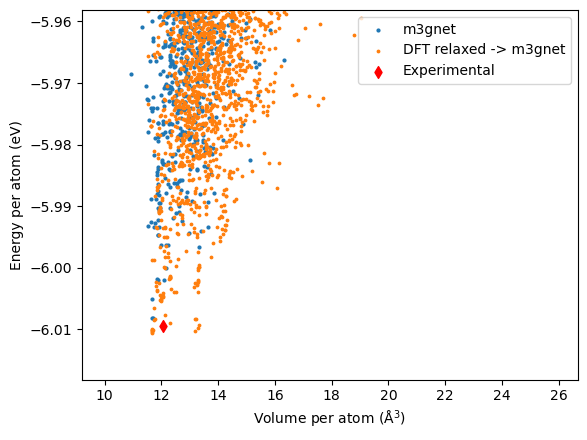

In [6]:
def add_labels(ax):
    """Add axis labels"""
    ax.set_ylabel('Energy per atom (eV)')
    ax.set_xlabel(r'Volume per atom ($\mathrm{\AA^3}$)')

ax = df_m3g.plot.scatter('volume_per_atom', 'energy_per_atom', label='m3gnet', s=4)
ax = df_relaxed_m3g.plot.scatter('volume_per_atom', 'energy_per_atom', label='DFT relaxed -> m3gnet', ax=ax, color='C1', s=3)
ax.scatter( [lifeso4f_mp_relaxed_volume], [lifeso4f_mp_relaxed_energy],  marker='d', color='r', label='Experimental')
min_eng = df_m3g.energy_per_atom.min()
#ax.set_xlim(10, 15)
ax.set_ylim(min_eng-0.01, min_eng+ 0.05)
ax.legend(loc=1)
add_labels(ax)

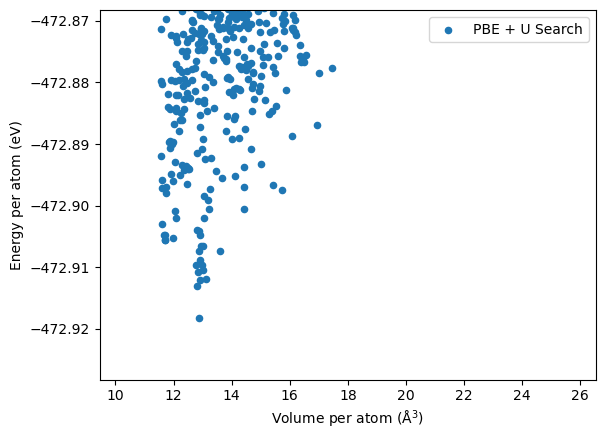

In [7]:
ax = df_dft.plot.scatter('volume_per_atom', 'energy_per_atom', 
                         #xlim=(9, 14), ylim=(-434, -433.75), 
                         label='PBE + U Search')
min_eng = df_dft.energy_per_atom.min()
ax.set_ylim(min_eng-0.01, min_eng+ 0.05)

ax.legend(loc=1)
add_labels(ax)

Top structure found in each case are shown below.
In this case, the M3GNet gives completely different low energy structures which are
different to the experimentally found tavorite structure.
This is also shown in the distribution plot above where the orange dots
do not overlap with the red diamonds (experimental structure).

In [8]:
show_compact(df_m3g.iloc[:5])

,label,energy_per_atom,volume_per_atom
989,2LiFeSO4F-200804-055229-a4aef3,-6.008125,11.683317
612,2LiFeSO4F-200804-043547-80a807,-6.008113,11.704279
1113,2LiFeSO4F-200818-200625-fa2e89,-6.005019,11.657444
301,2LiFeSO4F-200804-031846-78332d,-6.001975,12.084385
1471,2LiFeSO4F-200819-000200-50146f,-6.001975,11.862633


On the other hand, re-relaxing the DFT relaxed structure gives different sets low energy structures,
one has a volume per atom of about 11.8 $\mathrm{\AA^3}$ while the other has a volume of about 13.2 $\mathrm{\AA^3}$.

In [9]:
show_compact(df_relaxed_m3g.iloc[:5])

,label,energy_per_atom,volume_per_atom
993,2LiFeSO4F-200818-173807-f55f90,-6.010575,11.660858
2763,4LiFeSO4F-200804-093629-270f26,-6.010425,11.663456
612,2LiFeSO4F-200804-043547-80a807,-6.010275,11.670359
400,2LiFeSO4F-200804-034722-678938,-6.010187,13.186974
1471,2LiFeSO4F-200819-000200-50146f,-6.010144,11.676132


In fact, the sets of low energy structures with large volumes contains the new polymorphs found in the
DFT search previously.
Structure *f55f90* (in `df_relaxed_m3g`) and *a4aef3* in (`df_m3g`) has almost the same structure but the energies are different by 2 meV and almost identical structures have been found for them separately.

In [10]:
show_compact(df_dft.iloc[:3])

,label,energy_per_atom,volume_per_atom
400,2LiFeSO4F-200804-034722-678938,-472.918226,12.890395
129,2LiFeSO4F-200804-022644-43b3f4,-472.913076,12.803132
117,2LiFeSO4F-200804-022154-9da9fb,-472.912053,12.918566


## Energy distribution of the relaxed structures

M3GNet seems to give an energy distribution among the relaxed structure very similar to 
that of the DFT.

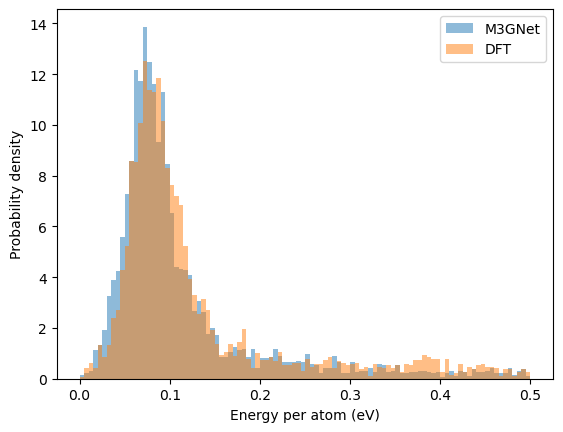

In [11]:
import matplotlib.pyplot as plt

engs = df_m3g['energy_per_atom'].values.copy()
engs_m3g = engs - lifeso4f_mp_relaxed_energy
engs = df_dft['energy_per_atom'].values.copy()
engs_dft = engs - engs.min()

plt.hist(engs_m3g, bins=100,alpha=0.5, density=True, range=(0, 0.5), label='M3GNet');
plt.hist(engs_dft, bins=100, alpha=0.5, density=True, range=(0, 0.5), label='DFT');
plt.legend()
plt.xlabel('Energy per atom (eV)')
plt.ylabel('Probability density');

## Discussion

Search using M3GNet for relaxation is not able to fully reproduce the DFT results, 
and it tends to find a cluster of structure with smaller volumes.
On the other hand, M3GNet does give a reasonable good description for the low energy structures. 
In particular, the DFT lowest energy structure `678938` is also found to be one of the lowest energy structure when
the DFT relaxed structure is further relaxed using M£GNet.
This suggests that M3GNet does well when interpolating - even if there are little $\ce{LiFeSO4F}$ data in the training set, 
there are plenty of training data in the composition space of Li-Fe-S-O-F.